# MNIST Digit Classification

## Recurrent Neural Nets

####  *Binu Jasim, PhD Scholar, CVIT, IIIT Hyderabad*

To better understand RNNs, let's try image classification.

## A few standard imports

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torchvision.utils import make_grid
%matplotlib inline


## A few global parameters, to make our lives easier.

In [2]:
DATA_ROOT = 'data/'
batch_size = 20
epochs = 5
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## MNIST Dataset

MNIST is a standard dataset of 28x28 images of handwritten digits from 0-9. There are 60,000 training images and 10k test images.

### Loading Data

We'll follow pytorch recommended semantics, and use a dataloader to load the data. 

In [3]:
# train data
mnist_path = os.path.join(DATA_ROOT, 'mnist')
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(mnist_path, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

# test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(mnist_path, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=batch_size, shuffle=False)

### Take a look at the data?

We use `torchvision.utils.make_grid` to get a nice view of the data, you'll often in tutorials.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


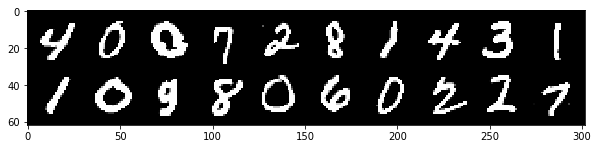

In [4]:
sample = next(iter(train_loader))
samples, truths = sample
for_grid = samples.squeeze(0)[:30, :, :, :]
img = make_grid(for_grid, nrow=10)
C, W, H = 0, 1, 2
img = img.permute(W, H, C)
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='jet')
plt.show()

## Describing the input

Unlike CNNs, RNNs can take in variable length sequences and takes in one input vector at a time. In context of MNIST, we take a look at how to formulate it for our problem.


Consider an image as a sequence of column pixels. 

For example if the original image is 28x28, then we consider it a sequence of length 28 with each element of the sequence being a 28 dimensional column vector. Our objective is to correctly predict the class of the image.

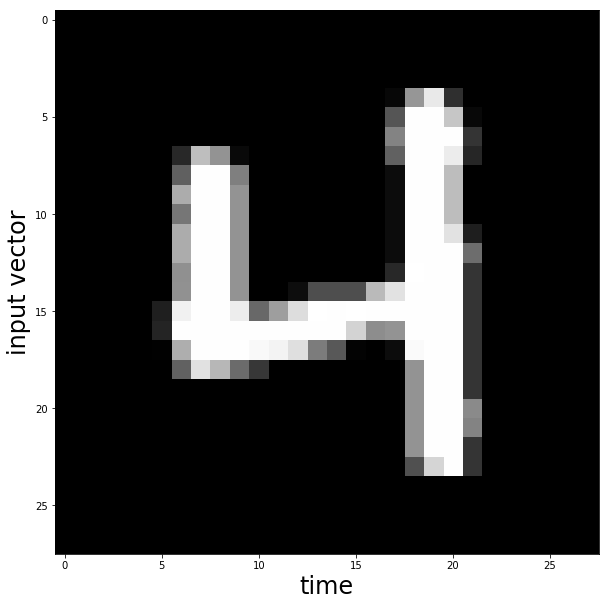

In [5]:
sample = next(iter(train_loader))
samples, truths = sample
img = samples.squeeze(1)[0]
W, H = 0, 1
img = img.permute(W, H)
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.xlabel("time", fontsize=24)
plt.ylabel("input vector", fontsize=24)
plt.show()

We'll use the images' x width as the time ax, and the column corresponding to each point as the input vector. 

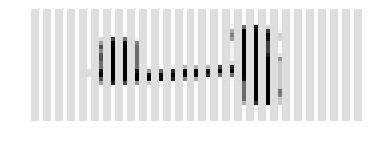

In [6]:
img2 = img.clone()
white = img2.max().item()
black = img2.min().item()
img2 = white - img2 # invert
plt.imshow(img2, cmap='gray')
H, W = img2.size()
placeholder = img2.new_full((H, 3*W), white)
for t in range(W):
    placeholder[:, 3*t] = img2[:, t]
    
plt.imshow(placeholder, cmap='gray')
plt.axis("off")
plt.show()

## Define Model

### Types

![Courtesy: Karpathy, Unreasonable Effectiveness of RNNs](static/diags.jpeg)

Which one do you think we'll be using?

## Model Description
We define a recurrent network that predicts the MNIST image. The components
        required are:
        
- `gru`: applying the GRU on the sequential input returns an output for each token in the sequence
- `fc`: a fully connected layer that converts the LSTM output for each token to a distribution over classes


In [8]:
class RnnNet(nn.Module):
    def __init__(self, batch_size=10):
        
        super(RnnNet, self).__init__()
        self.input_dim = 28
        self.seq_len = 28
        self.hidden_dim = 100
        self.batch_size = batch_size
        self.num_class = 10
        
        self.rnn = nn.GRU(self.input_dim, self.hidden_dim, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, self.num_class)

    def forward(self, x):
       
        # h0 = torch.randn(1, self.batch_size, self.hidden_dim).to(device)
        # run the LSTM along the sequences of length seq_len
        
        _, x = self.rnn(x)      # dim (same as h0):  1 x batch_size x hidden_dim
        x = x.squeeze(0)        # dim: batch_size x hidden_dim
            
        x = self.fc(x)          # dim: batch_size x num_tags
        return F.log_softmax(x, dim=1)

## Piecing our work together

## Train Routine

In [9]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # data = data.view(-1, 784, 1) # original data is of dim: (batch_size x 1 x 28 x 28)
        data = data.squeeze(1)
        optimizer.zero_grad()
        output = model(data)
        # print(output.shape)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        #if batch_idx % log_interval == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.item()))



## Test Routine

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # data = data.view(-1, 784, 1) # original data is of dim: (batch_size x 1 x 28 x 28)
            data = data.squeeze(1)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Running 

In [11]:
model = RnnNet(batch_size=batch_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)#, momentum=0.9)

In [12]:
for epoch in tqdm(range(1, epochs + 1), desc='epoch'):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

/home/manisha.padala/env3/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Average loss: 0.1329, Accuracy: 9590/10000 (95.90%)
Test set: Average loss: 0.0587, Accuracy: 9830/10000 (98.30%)
Test set: Average loss: 0.0456, Accuracy: 9870/10000 (98.70%)
Test set: Average loss: 0.0556, Accuracy: 9831/10000 (98.31%)
Test set: Average loss: 0.0420, Accuracy: 9872/10000 (98.72%)



## Exercises/Questions

1. Instead of 28x28 sequence, what if we consider the image as a 1x784 sequence. How would you modify the RnnNet defined above? Why does it take more time to run?
2. MNIST looks like a character level OCR. In what ways would RNNs be better than CNNs at say OCR problems?